Number of numeric columns: 8
Original shape: (143468, 28)
Binary shape: (143468, 93)
Number of numeric columns: 8
Original shape: (72023, 28)
Binary shape: (72023, 93)


[I 2025-01-22 13:04:54,867] A new study created in memory with name: no-name-718b0212-5194-43cb-acc1-baef7bf9e721
[I 2025-01-22 13:04:59,657] Trial 0 finished with value: 0.9312640230559714 and parameters: {'num_leaves': 102, 'learning_rate': 0.052253428397055934, 'feature_fraction': 0.8219846813924576, 'bagging_fraction': 0.6824287440219505, 'bagging_freq': 4}. Best is trial 0 with value: 0.9312640230559714.
[I 2025-01-22 13:05:01,843] Trial 1 finished with value: 0.9314744227606058 and parameters: {'num_leaves': 121, 'learning_rate': 0.07746913584939372, 'feature_fraction': 0.518407725408797, 'bagging_fraction': 0.40135472019687995, 'bagging_freq': 2}. Best is trial 1 with value: 0.9314744227606058.
[I 2025-01-22 13:05:02,892] Trial 2 finished with value: 0.9192942591501774 and parameters: {'num_leaves': 16, 'learning_rate': 0.0250472203748825, 'feature_fraction': 0.6982802199243443, 'bagging_fraction': 0.6665127311724011, 'bagging_freq': 1}. Best is trial 1 with value: 0.93147442276

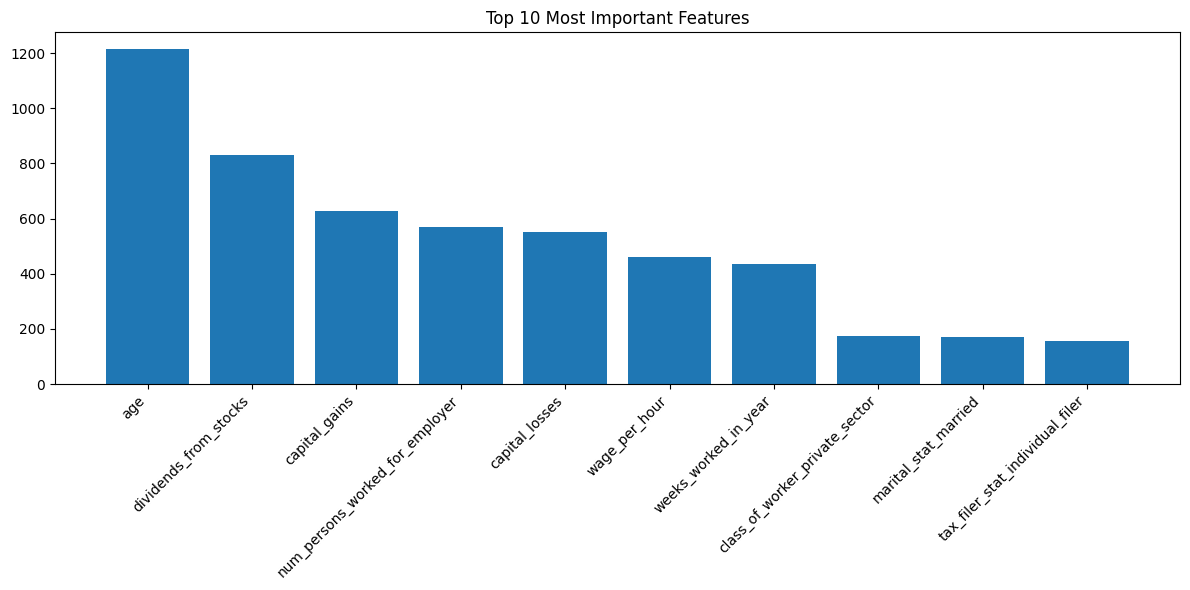

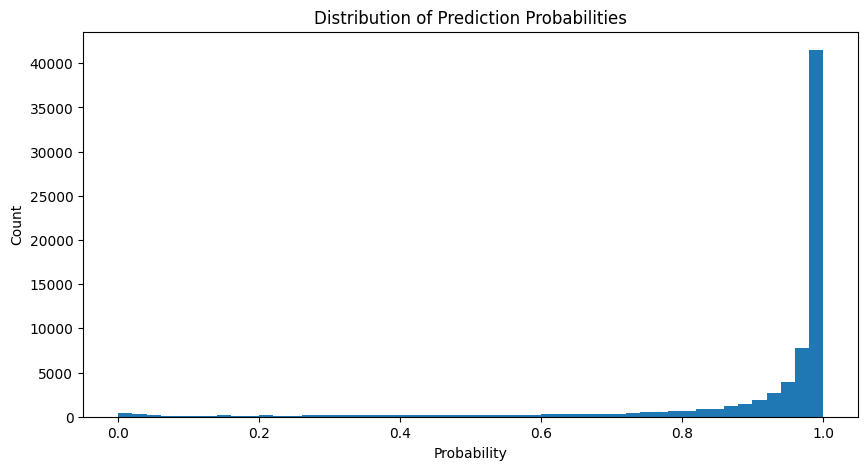

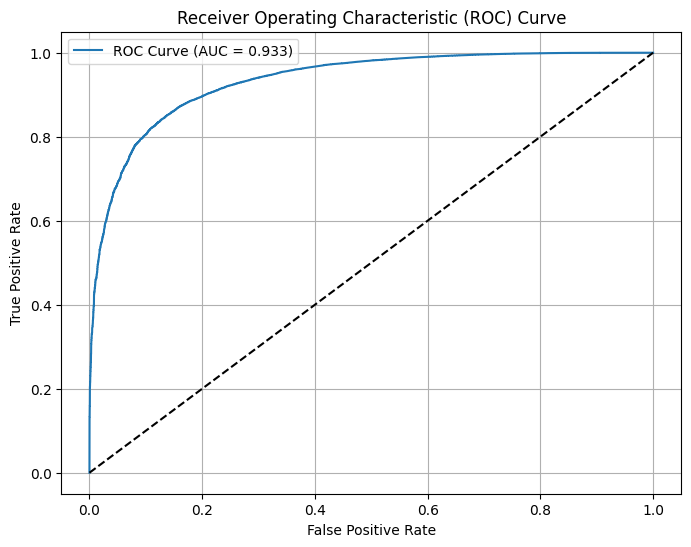

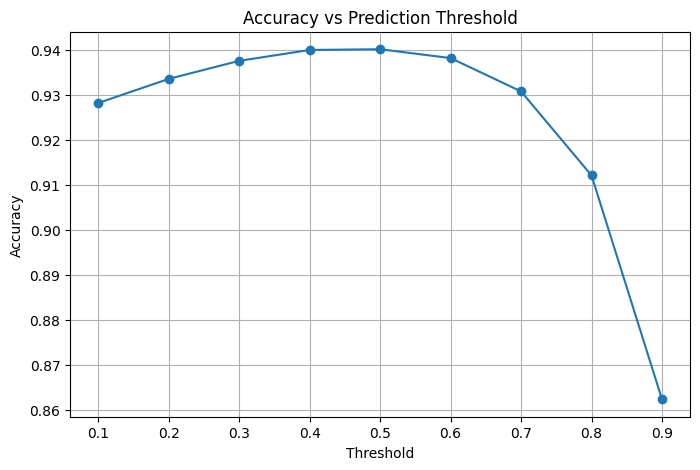

In [4]:
import logging
import pandas as pd
import numpy as np
from postprocessing import post_processing
from imblearn.under_sampling import OneSidedSelection
from collections import Counter
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
import optuna
import pickle
import os
import datetime

# Configure logging
filename = 'test'
ml_dir = 'ML'

train_dir = 'data/processed/census_income_learn.csv'
test_dir = 'data/processed/census_income_test.csv'
logging.basicConfig(filename=os.path.join(ml_dir, f'{filename}_report_test.log'), level=logging.INFO, format='%(message)s', filemode='w')
# Load the train/test data
logging.info(f'fitting model {filename} started at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M')}')
logging.info("\nTrain data: ###############################")
X_train, y_train = post_processing(train_dir, get_dummies= True, over_18= True)
X_train = X_train.astype(int)
logging.info(f'\nX_train shape: {X_train.shape}')

logging.info("\nTest data: ###############################")
X_test, y_test = post_processing(test_dir, get_dummies= True, over_18= True)
X_test = X_test.astype(int)
logging.info(f'\nX_test shape: {X_test.shape}')

# Perform OSS
oss = OneSidedSelection(random_state=42)
X_train_oss, y_train_oss = oss.fit_resample(X_train, y_train)

# Print class distribution before and after OSS
logging.info("\nOriginal class distribution:")
logging.info(Counter(y_train))
logging.info("\nResampled class distribution after OSS:")
logging.info(Counter(y_train_oss))

# Create dataset for LightGBM using OSS resampled data
train_data = lgb.Dataset(X_train_oss, y_train_oss)
test_data = lgb.Dataset(X_test, y_test, reference=train_data)

# Define the objective function for Optuna

num_rounds = 100
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 15, 127),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'verbose': 0
    }
    
    # Train model with current parameters
    model = lgb.train(
        params,
        train_data,
        num_rounds,
        valid_sets=[test_data],
        # early_stopping_rounds=20,
        # verbose_eval=False
    )
    
    # Get validation score
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred)

# Create and run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get best parameters
best_params = study.best_params
best_params.update({
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'verbose': 0
})

logging.info("\nBest parameters found: %s", best_params)

# Train final model with best parameters
num_rounds = 100
model = lgb.train(
    best_params,
    train_data,
    num_rounds,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid']
)

# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = np.round(y_pred_proba)

# Evaluate model
logging.info("\nModel Evaluation:")
logging.info("-----------------")
logging.info(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
logging.info(f"\nROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
logging.info("\nClassification Report:")
logging.info(f'\n{classification_report(y_test, y_pred)}')

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)
logging.info("\nTop 10 Most Important Features:")
logging.info(f'\n{feature_importance.head(15)}')

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
logging.info('\nconfusion_matrix:')
logging.info(cm)
logging.info("--------------------")
# Print confusion matrix values in a tabular format
logging.info("\nConfusion Matrix Values:")
logging.info("--------------------")
logging.info(f"\nTrue Negatives (TN): {cm[0][0]}")
logging.info(f"\nFalse Positives (FP): {cm[0][1]}")
logging.info(f"\nFalse Negatives (FN): {cm[1][0]}")
logging.info(f"\nTrue Positives (TP): {cm[1][1]}")

# Calculate and print percentages
total = cm.sum()
logging.info("\nConfusion Matrix Percentages:")
logging.info("\n-------------------------")
logging.info(f"\nTrue Negatives (TN): {(cm[0][0]/total)*100:.2f}%")
logging.info(f"\nFalse Positives (FP): {(cm[0][1]/total)*100:.2f}%")
logging.info(f"\nFalse Negatives (FN): {(cm[1][0]/total)*100:.2f}%")
logging.info(f"\nTrue Positives (TP): {(cm[1][1]/total)*100:.2f}%")

# Plot and analyze feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
# plt.show()

# Analyze correlation between top features and predictions
top_features = feature_importance['feature'][:5].tolist()
correlations = pd.DataFrame()
for feature in top_features:
    correlations[feature] = pd.Series({
        'correlation_with_prediction': np.corrcoef(X_test[feature], y_pred)[0,1],
        'mean_value_when_predicted_1': X_test[feature][y_pred == 1].mean(),
        'mean_value_when_predicted_0': X_test[feature][y_pred == 0].mean()
    })

logging.info("\nFeature Correlation Analysis:")
logging.info(f'\n{correlations}')
logging.info("\n--------------------")

# Model performance metrics
logging.info("\nDetailed Model Performance Metrics:")
logging.info(f"\nAccuracy: {np.mean(y_pred == y_test):.4f}")
logging.info(f"\nTrue Positive Rate: {cm[1,1] / (cm[1,0] + cm[1,1]):.4f}")
logging.info(f"\nTrue Negative Rate: {cm[0,0] / (cm[0,0] + cm[0,1]):.4f}")
logging.info(f"\nPositive Predictive Value: {cm[1,1] / (cm[0,1] + cm[1,1]):.4f}")

# Distribution of probabilities
plt.figure(figsize=(10, 5))
plt.hist(y_pred_proba, bins=50)
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Probability')
plt.ylabel('Count')
# plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_curve_vals = {'fpr' : fpr, 'tpr' : tpr}
roc_curve_vals = pd.DataFrame(roc_curve_vals)
logging.info(f'\n{roc_curve_vals}')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
# plt.show()

# Additional model insights
logging.info("\nModel Configuration:")
logging.info("\n--------------------")
logging.info(f"\nNumber of training rounds: {num_rounds}")
logging.info("\nModel Parameters:")
for key, value in best_params.items():
    logging.info(f"\n{key}: {value}")

# Training data balance analysis
logging.info("\nClass Distribution in Training Data:")
logging.info(f"\nClass counts: \n{y_train.value_counts()}")
logging.info(f"\nClass proportions: \n{y_train.value_counts(normalize=True)}")
# Print model's training history
logging.info("\nTraining History:")
logging.info("\n----------------")
evals_result = {}
for metric, values in model.best_score.items():
    logging.info(f"\n{metric}: {values}")

# Feature importance percentages
total_importance = feature_importance['importance'].sum()
feature_importance['importance_percentage'] = (feature_importance['importance'] / total_importance * 100).round(2)
logging.info("\nFeature Importance Percentages (Top 10):")
logging.info(f'\n{feature_importance[['feature', 'importance_percentage']].head(15)}')

# Calculate prediction threshold analysis
thresholds = np.arange(0.1, 1.0, 0.1)
threshold_metrics = []
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    acc = accuracy_score(y_test, y_pred_thresh)
    threshold_metrics.append({'threshold': thresh, 'accuracy': acc})

threshold_df = pd.DataFrame(threshold_metrics)
logging.info("\nPrediction Threshold Analysis:")
logging.info(f'\n{threshold_df}')

# Plot threshold analysis
plt.figure(figsize=(8, 5))
plt.plot(threshold_df['threshold'], threshold_df['accuracy'], marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Prediction Threshold')
plt.grid(True)
# plt.show()

# Model complexity analysis
logging.info("\nModel Complexity Analysis:")
logging.info(f"\nNumber of trees: {model.num_trees()}")
logging.info(f"\nTotal number of leaves: {model.num_trees() * best_params['num_leaves']}")

# Analyze prediction confidence
confidence_bins = pd.cut(y_pred_proba, bins=15)
confidence_analysis = pd.DataFrame({
    'prediction_confidence': confidence_bins,
    'actual': y_test
}).groupby('prediction_confidence').agg({
    'actual': ['count', 'mean']
})

logging.info("\nPrediction Confidence Analysis:")
logging.info(f'\n{confidence_analysis}')        




# Save the model as a pickle file
logging.info("\nModel saved as best_model.pkl")

In [13]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# False Positive Analysis
print(y_pred.shape)
print(y_test.shape)
print(X_test.shape)

FP = X_test.reset_index()
FP['y_pred'] = y_pred
FP['y_true'] = y_test.reset_index(drop=True)

(72023,)
(72023,)
(72023, 82)


In [14]:
# cross validate
FP[(FP['y_pred'] == 1) & (FP['y_true'] == 0)]['y_pred'].value_counts()

y_pred
1.0    3143
Name: count, dtype: int64

In [15]:
FP1 = FP[(FP['y_pred'] == 1)]

In [32]:
def plot_sorted_distribution(df: pd.DataFrame, x: str, hue: str = 'target', figsize: tuple =(6,4), save:bool = False):
    """
    Create a sorted percentage distribution plot
    
    Parameters:
    df (DataFrame): Input dataframe
    x (str): Column name for x-axis
    hue (str): Column name for hue/color separation
    figsize (tuple): Figure size (width, height)
    """
    sns.set_theme(style="ticks")
    plt.figure(figsize=figsize)

    # Calculate proportions and sort categories
    proportions = df.groupby(x)[hue].mean().sort_values(ascending=False)
    sorted_categories = proportions.index.tolist()

    # Create the plot with sorted categories
    sns.histplot(
        data=df, 
        x=df[x].astype('category').cat.reorder_categories(sorted_categories), 
        hue=hue, 
        stat='percent', 
        multiple="fill"
    )

    plt.ylabel('Percentage')
    plt.legend(labels=['Under 50K', 'Above 50K'], title='Income Level')
    plt.xticks(rotation=45, ha='right')
    if save:
        plt.savefig(f'{x}_income')
    pass


def plot_kde_distribution(df: pd.DataFrame, x: str, hue: str = 'target', figsize: tuple = (8, 6), 
                         fill: bool = True, alpha: float = 0.5, common_norm: bool = False,
                         title: str = None, save: bool = False):
    """
    Create a KDE plot for numerical variables
    
    Parameters:
    df (DataFrame): Input dataframe
    x (str): Column name for x-axis
    hue (str): Column name for hue/color separation
    figsize (tuple): Figure size (width, height)
    fill (bool): Whether to fill the KDE plot
    alpha (float): Transparency of the fill
    common_norm (bool): Whether to normalize the KDE plots together
    title (str): Plot title (optional)
    save (bool): Whether to save the plot
    """
    sns.set_theme(style="ticks")
    plt.figure(figsize=figsize)
    
    # Filter out zero values if present
    
    sns.kdeplot(data=df, x=x, hue=hue, fill=fill, alpha=alpha, common_norm=common_norm)
    plt.title(title)
    plt.ylabel('Density')
    plt.legend(labels=['Under 50K', 'Above 50K'])
    
    if save:
        plt.savefig(f'{x}_income_kde')
    pass

def plot_boxplot_distribution(df: pd.DataFrame, x: str, hue: str = 'target', figsize: tuple = (8, 6), 
                         fill: bool = True, alpha: float = 0.5, common_norm: bool = False,
                         title: str = None, save: bool = False):
    """
    Create a boxplot for numerical variables
    
    Parameters:
    df (DataFrame): Input dataframe
    x (str): Column name for x-axis
    hue (str): Column name for hue/color separation
    figsize (tuple): Figure size (width, height)
    fill (bool): Whether to fill the boxplot
    alpha (float): Transparency of the fill
    common_norm (bool): Whether to normalize the plots together
    title (str): Plot title (optional)
    save (bool): Whether to save the plot
    """
    sns.set_theme(style="ticks")
    plt.figure(figsize=figsize)
    
    # Create boxplot
    sns.boxplot(data=df, x=hue, y=x)
    
    plt.xlabel('Income Level')
    plt.ylabel(x)
    plt.xticks([0, 1], ['Under 50K', 'Above 50K'])
    
    if title:
        plt.title(title)
    
    if save:
        plt.savefig(f'{x}_income_boxplot')
    pass

def join_binary_columns(df, prefix, sep='_'):
    """
    Combines binary columns back into a single categorical column.
    Example: columns ['color_red', 'color_blue'] -> 'color' column with values ['red', 'blue']
    """
    # Get relevant columns
    cols = [c for c in df.columns if c.startswith(prefix + sep)]
    
    # For each row, get the category name where value is 1
    categories = [c.replace(prefix + sep, '') for c in cols]
    return pd.Series([categories[row.values.argmax()] for _, row in df[cols].iterrows()])

In [17]:
FP1['race'] = join_binary_columns(FP1, 'race_')
FP1['class_of_worker'] = join_binary_columns(FP1, 'class_of_worker')
FP1['major_industry_code_'] = join_binary_columns(FP1, 'major_industry_code_')
FP1['education'] = join_binary_columns(FP1, 'education')
FP1['enroll_in_edu_inst_last_wk_'] = join_binary_columns(FP1, 'enroll_in_edu_inst_last_wk_')
FP1['full_or_part_time_employment_stat'] = join_binary_columns(FP1, 'full_or_part_time_employment_stat')
FP1['live_in_this_house_1_year_ago_'] = join_binary_columns(FP1, 'live_in_this_house_1_year_ago_')
FP1['marital_stat_'] = join_binary_columns(FP1, 'marital_stat')
FP1['reason_for_unemployment'] = join_binary_columns(FP1, 'reason_for_unemployment')
FP1['migration_prev_res_in_sunbelt'] = join_binary_columns(FP1, 'migration_prev_res_in_sunbelt_')
FP1['citizenship'] = join_binary_columns(FP1, 'citizenship')
FP1['own_business_or_self_employed'] = join_binary_columns(FP1, 'own_business_or_self_employed')
FP1['region_of_previous_residence'] = join_binary_columns(FP1, 'region_of_previous_residence_')

C:\Users\Amin\AppData\Local\Temp\ipykernel_17728\1925839199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FP1['race'] = join_binary_columns(FP1, 'race_')
C:\Users\Amin\AppData\Local\Temp\ipykernel_17728\1925839199.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FP1['class_of_worker'] = join_binary_columns(FP1, 'class_of_worker')
C:\Users\Amin\AppData\Local\Temp\ipykernel_17728\1925839199.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

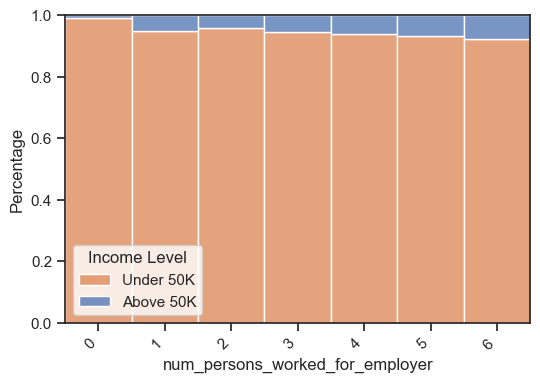

In [21]:
plot_sorted_distribution(
    df= FP1,
    x = 'num_persons_worked_for_employer'
    ,hue= 'y_true')

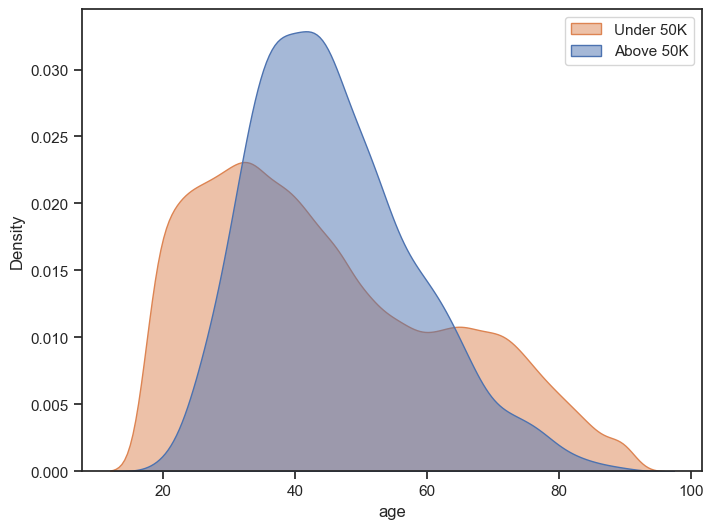

In [33]:
plot_kde_distribution(
    df= FP1,
    x = 'age',
    hue= 'y_true')

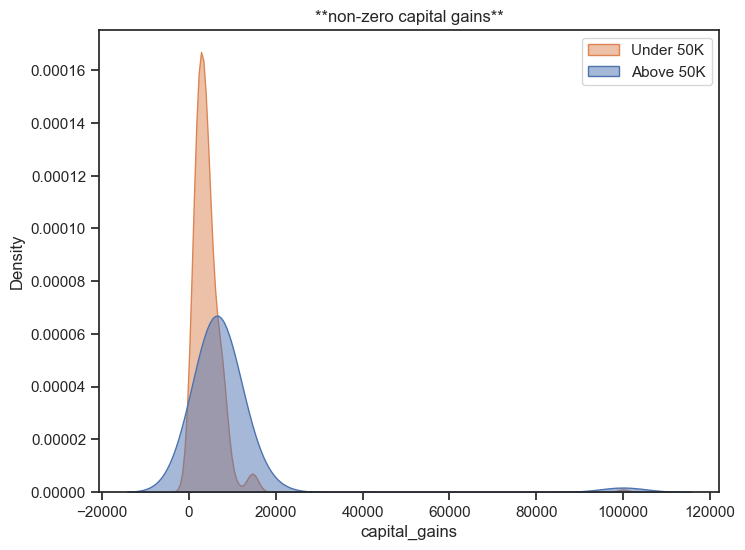

In [36]:
plot_kde_distribution(
    df= FP1[FP1['capital_gains'] > 0],
    x = 'capital_gains',
    title= '**non-zero capital gains**',
    hue= 'y_true')

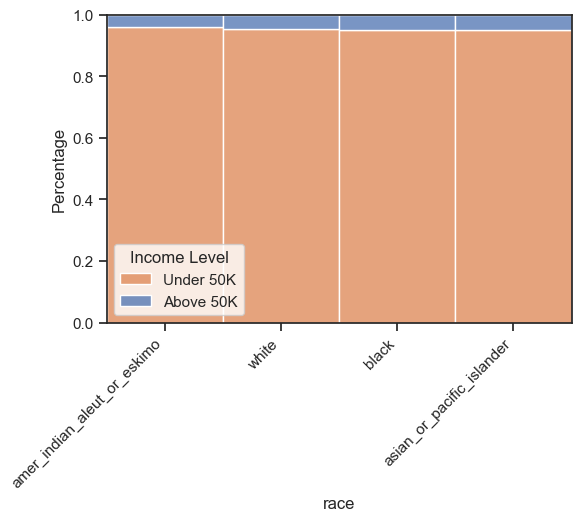

In [37]:
plot_sorted_distribution(
    df= FP1,
    x = 'race',
    hue='y_true'
)

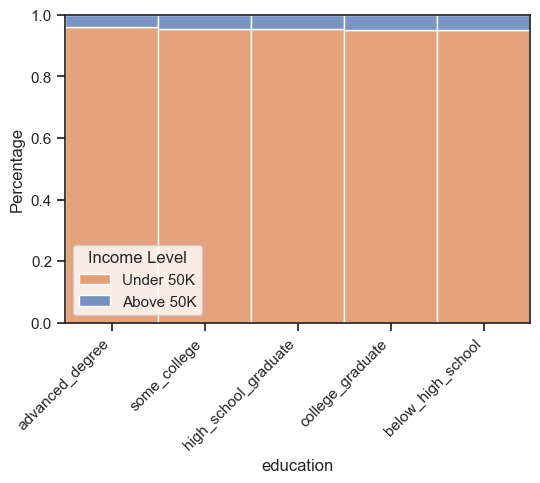

In [38]:
plot_sorted_distribution(
    df= FP1,
    x = 'education',
    hue='y_true'
)

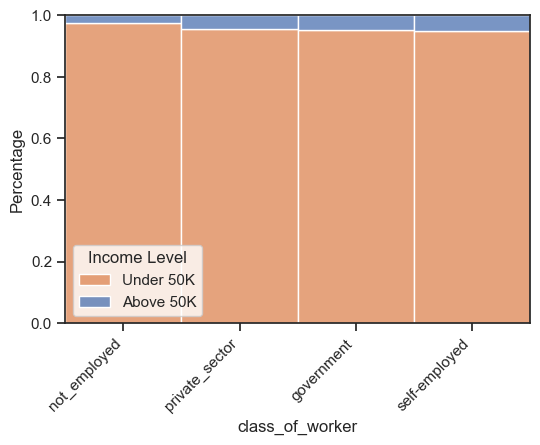

In [39]:
plot_sorted_distribution(
    df= FP1,
    x = 'class_of_worker',
    hue='y_true'
)

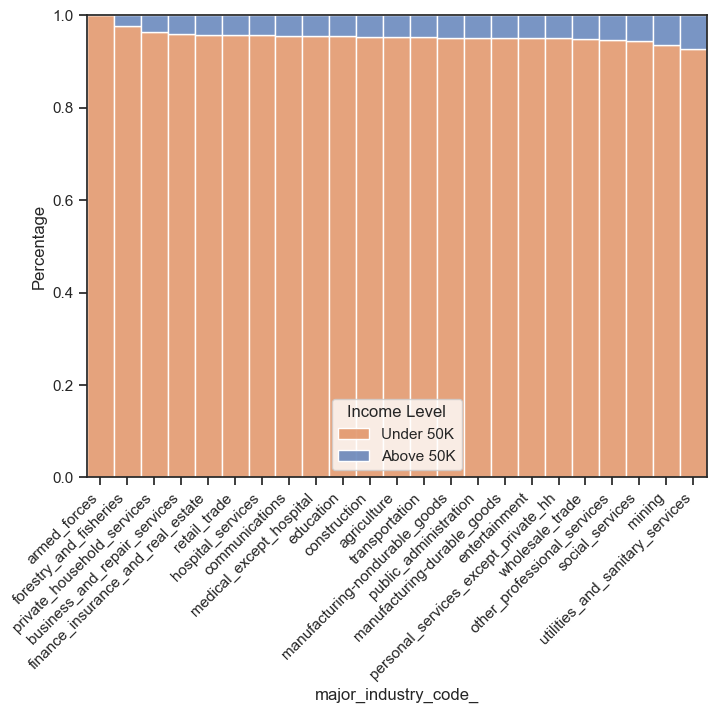

In [42]:

plot_sorted_distribution(
    df= FP1,
    x = 'major_industry_code_',
    hue='y_true',
    figsize=(8,6)
)

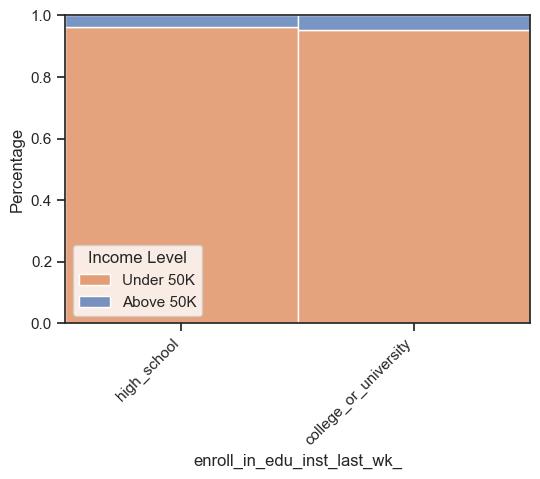

In [44]:

plot_sorted_distribution(
    df= FP1,
    x = 'enroll_in_edu_inst_last_wk_',
    hue='y_true',
    # figsize=(8,6)
)

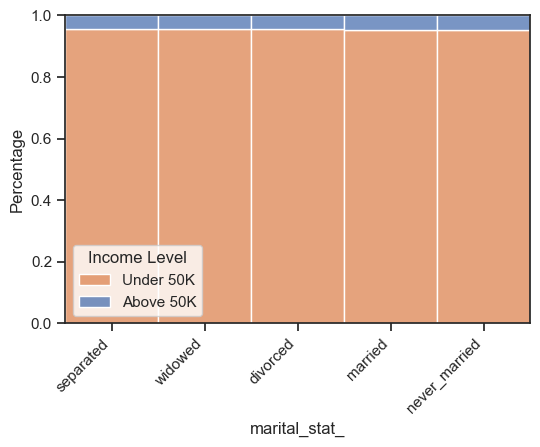

In [45]:

plot_sorted_distribution(
    df= FP1,
    x = 'marital_stat_',
    hue='y_true',a
    # figsize=(8,6)
)

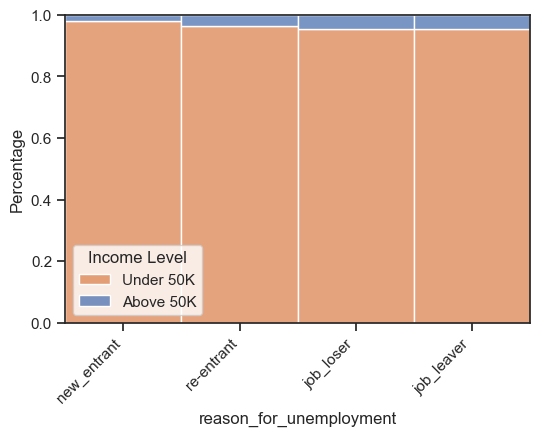

In [46]:

plot_sorted_distribution(
    df= FP1,
    x = 'reason_for_unemployment',
    hue='y_true',
    # figsize=(8,6)
)

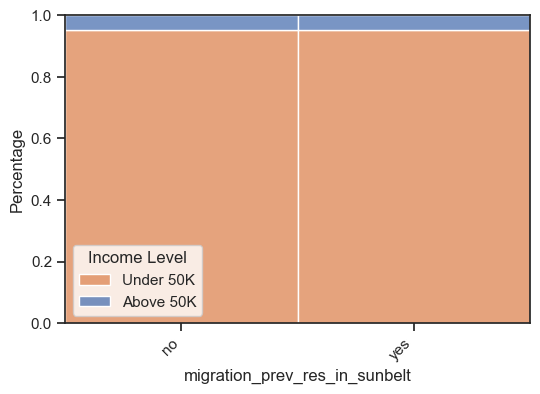

In [47]:

plot_sorted_distribution(
    df= FP1,
    x = 'migration_prev_res_in_sunbelt',
    hue='y_true',
    # figsize=(8,6)
)

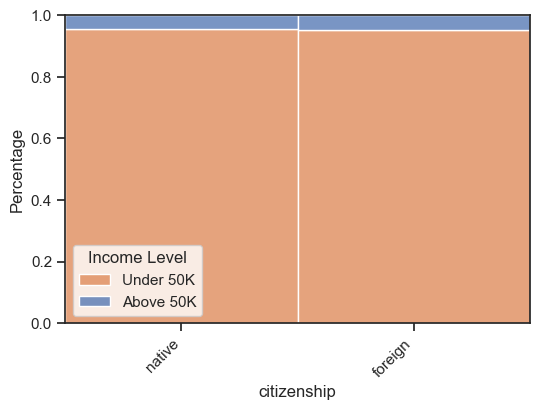

In [48]:

plot_sorted_distribution(
    df= FP1,
    x = 'citizenship',
    hue='y_true',
    # figsize=(8,6)
)

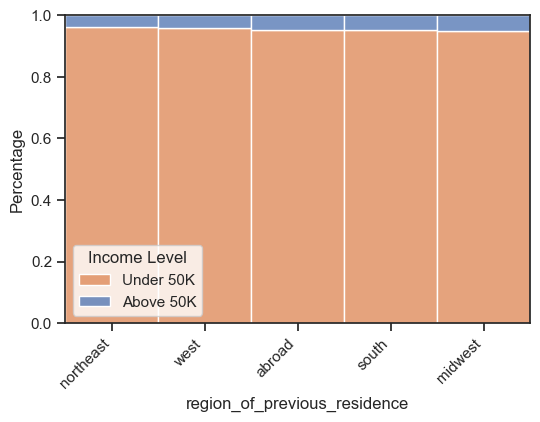

In [49]:



plot_sorted_distribution(
    df= FP1,
    x = 'region_of_previous_residence',
    hue='y_true',
    # figsize=(8,6)
)